# Prediction by Diagnosis Codes
In this notebook we build prediction model on the whole NRD database. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import os, sys

%matplotlib inline

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, concatenate, Reshape, BatchNormalization, add, LSTM, CuDNNLSTM, CuDNNGRU, Lambda
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


In [5]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import Mat_reg

## Data Preparation

In [6]:
core_dtypes_pd = {'AGE': float,
 'AWEEKEND': float,
 'DIED': float,
 'DISCWT': float,
 'DISPUNIFORM': float,
 'DMONTH': float,
 'DQTR': float,
 'DRG': float,
 'DRGVER': float,
 'DRG_NoPOA': float,
 'DX1': bytes,
 'DX10': bytes,
 'DX11': bytes,
 'DX12': bytes,
 'DX13': bytes,
 'DX14': bytes,
 'DX15': bytes,
 'DX16': bytes,
 'DX17': bytes,
 'DX18': bytes,
 'DX19': bytes,
 'DX2': bytes,
 'DX20': bytes,
 'DX21': bytes,
 'DX22': bytes,
 'DX23': bytes,
 'DX24': bytes,
 'DX25': bytes,
 'DX26': bytes,
 'DX27': bytes,
 'DX28': bytes,
 'DX29': bytes,
 'DX3': bytes,
 'DX30': bytes,
 'DX4': bytes,
 'DX5': bytes,
 'DX6': bytes,
 'DX7': bytes,
 'DX8': bytes,
 'DX9': bytes,
 'DXCCS1': float,
 'DXCCS10': float,
 'DXCCS11': float,
 'DXCCS12': float,
 'DXCCS13': float,
 'DXCCS14': float,
 'DXCCS15': float,
 'DXCCS16': float,
 'DXCCS17': float,
 'DXCCS18': float,
 'DXCCS19': float,
 'DXCCS2': float,
 'DXCCS20': float,
 'DXCCS21': float,
 'DXCCS22': float,
 'DXCCS23': float,
 'DXCCS24': float,
 'DXCCS25': float,
 'DXCCS26': float,
 'DXCCS27': float,
 'DXCCS28': float,
 'DXCCS29': float,
 'DXCCS3': float,
 'DXCCS30': float,
 'DXCCS4': float,
 'DXCCS5': float,
 'DXCCS6': float,
 'DXCCS7': float,
 'DXCCS8': float,
 'DXCCS9': float,
 'ECODE1': bytes,
 'ECODE2': bytes,
 'ECODE3': bytes,
 'ECODE4': bytes,
 'ELECTIVE': float,
 'E_CCS1': float,
 'E_CCS2': float,
 'E_CCS3': float,
 'E_CCS4': float,
 'FEMALE': float,
 'HCUP_ED': float,
 'HOSP_NRD': float,
 'KEY_NRD': float,
 'LOS': float,
 'MDC': float,
 'MDC_NoPOA': float,
 'NCHRONIC': float,
 'NDX': float,
 'NECODE': float,
 'NPR': float,
 'NRD_DaysToEvent': float,
 'NRD_STRATUM': float,
 'NRD_VisitLink': bytes,
 'ORPROC': float,
 'PAY1': float,
 'PL_NCHS': float,
 'PR1': bytes,
 'PR10': bytes,
 'PR11': bytes,
 'PR12': bytes,
 'PR13': bytes,
 'PR14': bytes,
 'PR15': bytes,
 'PR2': bytes,
 'PR3': bytes,
 'PR4': bytes,
 'PR5': bytes,
 'PR6': bytes,
 'PR7': bytes,
 'PR8': bytes,
 'PR9': bytes,
 'PRCCS1': float,
 'PRCCS10': float,
 'PRCCS11': float,
 'PRCCS12': float,
 'PRCCS13': float,
 'PRCCS14': float,
 'PRCCS15': float,
 'PRCCS2': float,
 'PRCCS3': float,
 'PRCCS4': float,
 'PRCCS5': float,
 'PRCCS6': float,
 'PRCCS7': float,
 'PRCCS8': float,
 'PRCCS9': float,
 'PRDAY1': float,
 'PRDAY10': float,
 'PRDAY11': float,
 'PRDAY12': float,
 'PRDAY13': float,
 'PRDAY14': float,
 'PRDAY15': float,
 'PRDAY2': float,
 'PRDAY3': float,
 'PRDAY4': float,
 'PRDAY5': float,
 'PRDAY6': float,
 'PRDAY7': float,
 'PRDAY8': float,
 'PRDAY9': float,
 'REHABTRANSFER': float,
 'RESIDENT': float,
 'SAMEDAYEVENT': bytes,
 'SERVICELINE': float,
 'TOTCHG': float,
 'YEAR': float,
 'ZIPINC_QRTL': float}

In [7]:
train_df = pd.read_csv(path+'cohorts/ami/DX_train.csv', dtype=core_dtypes_pd)
tst_df = pd.read_csv(path+'cohorts/ami/DX_tst.csv', dtype=core_dtypes_pd)

In [8]:
train_df = pd.read_csv(path+'all/DXs_train.csv', dtype=core_dtypes_pd)
tst_df = pd.read_csv(path+'all/DXs_tst.csv', dtype=core_dtypes_pd)

In [8]:
train_df.shape

(163671, 150)

In [9]:
trn_df, val_df = train_test_split(train_df, test_size=0.11, stratify=train_df.HOSP_NRD)
N_trn = len(trn_df)
N_val = len(val_df)

#train_df = pd.concat([trn_df, val_df])
all_df = pd.concat([train_df, tst_df])

## Multi-Level CCS Codes

### Define the parent matrix

Read the ICD9 CCS multi-level category dictionary file. 

In [7]:
multi_ccs = pd.read_csv(path+'ccs_multi_dx_tool_2015.csv')

multi_ccs.columns = ['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL1_LABEL', 'CCS_LVL2', 'CCS_LVL2_LABEL', 'CCS_LVL3', 'CCS_LVL3_LABEL', 
                    'CCS_LVL4', 'CCS_LVL4_LABEL']

multi_ccs.ICD9CM_CODE = multi_ccs.ICD9CM_CODE.apply(lambda x:x.replace("'", "").replace(' ', ''))
for j in range(1, 5):
    multi_ccs['CCS_LVL'+str(j)] = multi_ccs['CCS_LVL'+str(j)].apply(lambda x:x.replace("'", "").replace(' ', ''))

In [8]:
multi_ccs = multi_ccs[['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL2', 'CCS_LVL3', 'CCS_LVL4']]

In [21]:
multi_ccs.shape

(15072, 5)

In [23]:
multi_ccs.CCS_LVL1_LABEL.value_counts()

Injury and poisoning                                                                 2764
Residual codes; unclassified; all E codes [259. and 260.]                            1589
Diseases of the nervous system and sense organs                                      1587
Infectious and parasitic diseases                                                    1226
Complications of pregnancy; childbirth; and the puerperium                           1205
Neoplasms                                                                            1114
Diseases of the musculoskeletal system and connective tissue                          863
Diseases of the digestive system                                                      757
Mental Illness                                                                        597
Diseases of the circulatory system                                                    553
Diseases of the genitourinary system                                                  498
Endocrine;

Create one list to store all possible ICD9 code and their CCS multi-level in a list. Creat two dataframe to store the parent of each code and the indices of the parent. 

In [9]:
ccs_cat = pd.concat([multi_ccs.CCS_LVL1, multi_ccs.CCS_LVL2, multi_ccs.CCS_LVL3, multi_ccs.CCS_LVL4]).astype('category').cat.categories

In [15]:
len(ccs_cat), len(multi_ccs)

(728, 15072)

In [17]:
multi_ccs.head()

,CCS_LVL1,CCS_LVL2,CCS_LVL3,CCS_LVL4,finest_non_empty
ICD9CM_CODE,,,,,
01000,1,1.1,1.1.1,,1.1.1
01001,1,1.1,1.1.1,,1.1.1
01002,1,1.1,1.1.1,,1.1.1
01003,1,1.1,1.1.1,,1.1.1
01004,1,1.1,1.1.1,,1.1.1


In [13]:
all_codes = sorted(multi_ccs.ICD9CM_CODE) + list(ccs_cat[1:])

In [14]:
len(all_codes)

15799

In [16]:
multi_ccs = multi_ccs.set_index(multi_ccs.ICD9CM_CODE, drop=True).drop(['ICD9CM_CODE'], axis=1)

multi_ccs['finest_non_empty'] = multi_ccs.CCS_LVL4
multi_ccs.finest_non_empty[multi_ccs.finest_non_empty==''] = multi_ccs.CCS_LVL3[multi_ccs.finest_non_empty == '']
multi_ccs.finest_non_empty[multi_ccs.finest_non_empty==''] = multi_ccs.CCS_LVL2[multi_ccs.finest_non_empty == '']
multi_ccs.finest_non_empty[multi_ccs.finest_non_empty==''] = multi_ccs.CCS_LVL1[multi_ccs.finest_non_empty == '']

In [18]:
DX_parent = multi_ccs[['finest_non_empty']]
DX_parent.columns = ['parent_code']
DX_parent = DX_parent.assign(parent_index=DX_parent.parent_code.apply(lambda x:all_codes.index(x)).values)
DX_parent = DX_parent.append(pd.DataFrame(index=['incn', 'invl', 'missing'], data=dict(parent_code = ['NA']*3, 
                                                                                       parent_index=[-1]*3)))

In [22]:
CCS_parent = pd.DataFrame(dict(code=ccs_cat[1:]))
CCS_parent = CCS_parent.assign(parent_code=CCS_parent.code.apply(lambda x:'.'.join(x.split('.')[:-1])))

def get_CCS_ind(code):
    try:
        ind = all_codes.index(code)
    except ValueError:
        ind = -1
    return ind

CCS_parent = CCS_parent.assign(parent_index=CCS_parent.parent_code.apply(get_CCS_ind).values)
CCS_parent = CCS_parent.set_index(CCS_parent.code, drop=True).drop(['code'], axis=1)

In [23]:
CCS_parent.head()

,parent_code,parent_index
code,,
1,,-1
1.1,1,15072
1.1.1,1.1,15073
1.1.2,1.1,15073
1.1.2.1,1.1.2,15075


In [20]:
DX_parent.tail()

,parent_code,parent_index
V8905,18,15410
V8909,18,15410
incn,NA,-1
invl,NA,-1
missing,NA,-1


In [29]:
DX_parent.loc[DX_parent.parent_code=='18', 'parent_index'] = -1

In [24]:
parent_df = pd.concat([DX_parent, CCS_parent], axis=0)

In [35]:
parent_mat = np.identity(len(all_codes), dtype=int)

In [36]:
for i, c in enumerate(all_codes):
    parent_ind = parent_df.loc[c, 'parent_index']
    if not parent_ind == -1:
        parent_mat[i, parent_ind] = -1

In [37]:
no_parent = np.where(parent_mat.sum(axis=1)>0)[0]

In [38]:
np.array(all_codes)[no_parent]

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '2',
       '3', '4', '5', '6', '7', '8', '9'], dtype='<U9')

In [39]:
parent_mat = parent_mat[parent_mat.sum(axis=1)==0, :]

In [40]:
parent_mat.dtype

dtype('int64')

In [41]:
np.save(path+'all/parent_mat.npy', parent_mat)

### Data Formatting

Define the dictionaries for DX, DX1 and hosp, from value to int. 

In [42]:
DX_parent.index

Index(['01000', '01001', '01002', '01003', '01004', '01005', '01006', '01010',
       '01011', '01012',
       ...
       'V8812', 'V8901', 'V8902', 'V8903', 'V8904', 'V8905', 'V8909', 'incn',
       'invl', 'missing'],
      dtype='object', length=15075)

In [45]:
np.roll(np.arange(len(DX_parent)),-1)

array([    1,     2,     3, ..., 15073, 15074,     0])

In [46]:
DX_dict = dict(zip(sorted(DX_parent.index), np.roll(np.arange(len(DX_parent)),-1)))

In [50]:
all_codes[:10]

['0010',
 '0011',
 '0019',
 '0020',
 '0021',
 '0022',
 '0023',
 '0029',
 '0030',
 '0031']

In [49]:
DX_dict[all_codes[0]]

1

In [14]:
N_DX = 29
DXs = ['DX'+str(n) for n in range(2, N_DX+2)]

DX_series = pd.concat([all_df[DX] for DX in DXs])
DX_series = DX_series.fillna('missing')

In [15]:
DX_series = DX_series.astype('category')
DX_cat = DX_series.cat.categories
n_DX_cat = len(DX_cat)
DX_int_cat = list(range(n_DX_cat)[1:]) +[0]
DX_dict = dict(zip(DX_cat, DX_int_cat))

In [16]:
n_DX_cat

5458

In [17]:
DX1_series = all_df['DX1'].astype('category')
DX1_cat = DX1_series.cat.categories
DX1_int_cat = range(len(DX1_cat))

DX1_dict = dict(zip(DX1_cat, DX1_int_cat))

In [18]:
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories

hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

In [25]:
DX_df = train_df[DXs]
DX_df = DX_df.fillna('missing')

for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)

DX_mat = DX_df.values
DX_mat_trn = DX_df.values[:N_trn, ]
DX_mat_val = DX_df.values[N_trn:, ]

In [26]:
demo_mat = train_df[['AGE', 'FEMALE']].values

age_mean = train_df['AGE'].mean()
age_std = train_df['AGE'].std()

demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std

demo_mat_trn = demo_mat[:N_trn, ]
demo_mat_val = demo_mat[N_trn:, ]

In [27]:
hosp_series = train_df['HOSP_NRD'].map(hosp_dict)
hosp_array = hosp_series.values

hosp_array_trn = hosp_array[:N_trn]
hosp_array_val = hosp_array[N_trn:]

In [28]:
DX1_series = train_df['DX1'].map(DX1_dict)

DX1_mat = np.zeros((len(DX1_series), len(DX1_dict)))
for i, dx1 in enumerate(DX1_series.values):
    DX1_mat[i, dx1] = 1

DX1_mat_trn = DX1_mat[:N_trn, ]
DX1_mat_val = DX1_mat[N_trn:, ]

In [29]:
y = train_df['readm30'].values.astype(int)

Y_trn = to_categorical(y[:N_trn])
Y_val = to_categorical(y[N_trn:])

## Model Building

In [30]:
DX_embed_dim = 50
hosp_embed_dim = 1

In [31]:
parent_mat = np.load(path+'cohorts/ami/parent_mat.npy')

In [36]:
input_DX = Input(shape = (N_DX,))
DX_embed = Embedding(input_dim=len(all_codes), output_dim=DX_embed_dim, input_length=N_DX, mask_zero=True,
                     embeddings_regularizer=ccs_reg, name='DX_embed')(input_DX)

#DX_out, _, DX_feature = CuDNNLSTM(DX_embed_dim, return_sequences=False, return_state=True)(DX_embed)
#DX_feature = Lambda(lambda x: K.sum(x, axis=1))(DX_embed)
DX_feature = LSTM(DX_embed_dim, return_sequences=False)(DX_embed)

In [124]:
input_DX = Input(shape = (N_DX,))
DX_embed = Embedding(input_dim=parent_mat.shape[1], output_dim=DX_embed_dim, input_length=N_DX,
                     embeddings_regularizer=Mat_reg(parent_mat, 0.0005), name='DX_embed')(input_DX)

#DX_out, _, DX_feature = CuDNNLSTM(DX_embed_dim, return_sequences=False, return_state=True)(DX_embed)
DX_feature = Lambda(lambda x: K.sum(x, axis=1))(DX_embed)
#DX_feature = CuDNNLSTM(DX_embed_dim, return_sequences=False)(DX_embed)

In [125]:
input_demo = Input(shape=(2, ))

input_DX1 = Input(shape=(len(DX1_cat),))

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, DX_feature, hosp_embed], axis=1)

x = Dense(32, activation='relu')(merged)
#x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [41]:
model.layers[2].weights

[<tf.Variable 'DX_embed/embeddings:0' shape=(6100, 50) dtype=float32_ref>]

In [126]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [127]:
checkpoint = ModelCheckpoint(filepath=model_path+'ami_ccs_lstm_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_ccs_lstm_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[demo_mat_val, DX1_mat_val, DX_mat_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=30)

In [97]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [128]:
hist = model.fit([demo_mat_trn, DX1_mat_trn, DX_mat_trn, hosp_array_trn], Y_trn, 
                 batch_size=256, epochs=100, callbacks=[checkpoint, auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[demo_mat_val, DX1_mat_val, DX_mat_val, hosp_array_val], Y_val], 
                verbose=1)

Train on 145667 samples, validate on 18004 samples
Epoch 1/100
145667/145667 [==============================] - 9s 64us/step - loss: 1.3494 - val_loss: 0.6567
AUC: 0.6966

Epoch 2/100
145667/145667 [==============================] - 3s 20us/step - loss: 1.2714 - val_loss: 0.6480
AUC: 0.7034

Epoch 3/100
145667/145667 [==============================] - 3s 20us/step - loss: 1.2543 - val_loss: 0.6254
AUC: 0.7053

Epoch 4/100
145667/145667 [==============================] - 3s 20us/step - loss: 1.2446 - val_loss: 0.6704
AUC: 0.7059

Epoch 5/100
145667/145667 [==============================] - 3s 20us/step - loss: 1.2370 - val_loss: 0.6207
AUC: 0.7058

Epoch 6/100
145667/145667 [==============================] - 3s 20us/step - loss: 1.2281 - val_loss: 0.6270
AUC: 0.7060

Epoch 7/100
145667/145667 [==============================] - 3s 20us/step - loss: 1.2199 - val_loss: 0.6185
AUC: 0.7067

Epoch 8/100
145667/145667 [==============================] - 3s 20us/step - loss: 1.2155 - val_loss: 0

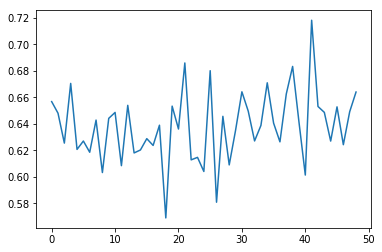

In [129]:
plt.plot(hist.history['val_loss'])

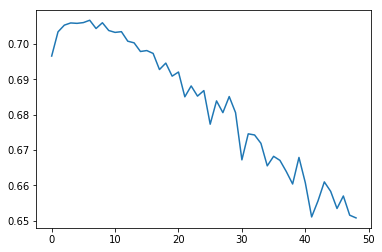

In [130]:
plt.plot(auccheckpoint.auc_history)

### Model testing

In [53]:
DX_df_tst = tst_df[DXs]
DX_df_tst = DX_df_tst.fillna('missing')

for dx in DXs:
    DX_df_tst[dx] = DX_df_tst[dx].map(DX_dict)

DX_mat_tst = DX_df_tst.values

In [54]:
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std

In [55]:
hosp_array_tst = tst_df['HOSP_NRD'].map(hosp_dict).values

In [56]:
DX1_series_tst = tst_df.DX1.map(DX1_dict)

DX1_mat_tst = np.zeros((len(tst_df), len(DX1_dict)))
for i, dx1 in enumerate(DX1_series_tst.values):
    DX1_mat_tst[i, dx1] = 1

In [131]:
model.load_weights(model_path+'ami_ccs_lstm_auc1.h5')

In [132]:
y = model.predict([demo_mat_tst, DX1_mat_tst, DX_mat_tst, hosp_array_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

18186/18186 [==============================] - 0s 27us/step


{0: 0.7084081464810368}

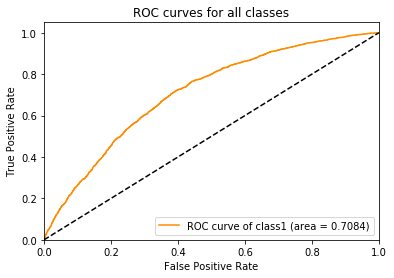

In [133]:
plot_roc(y_pred, y_true)

In [135]:
embed_trained = model.layers[2]

embed_mat = embed_trained.get_weights()[0]

In [72]:
np.linalg.norm(embed_mat, axis=1, ord=2)[:20]

array([0.13445328, 0.01330469, 0.01692051, 0.01324792, 0.01288445,
       0.01326387, 0.0132484 , 0.01324365, 0.01305246, 0.01320876,
       0.01324838, 0.013367  , 0.01326561, 0.0132235 , 0.0132535 ,
       0.01358849, 0.01516505, 0.01328224, 0.01323698, 0.01324947],
      dtype=float32)

In [120]:
np.linalg.norm(np.dot(parent_mat, embed_mat), axis=1, ord=2)[:20]

array([1.67420201e-02, 1.25085167e-03, 3.88638256e-04, 1.11788415e-02,
       9.17833277e-03, 5.80740744e-03, 1.52295803e-03, 3.01085294e-02,
       6.11861637e-03, 8.90269510e-03, 2.30148840e-02, 5.32340409e-04,
       5.70435590e-03, 2.60904864e-03, 5.05236697e-03, 5.88568662e-02,
       1.29949138e-02, 8.28027064e-05, 9.94104499e-03, 3.17214810e-03])

In [67]:
from sklearn import decomposition, manifold

In [68]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

In [136]:
embed_tsne = tsne.fit_transform(embed_mat[1:(n_DX_cat-2),:])

In [ ]:
ccs_lvl1 = [ami_ccs.loc[c, 'CCS_LVL1'] for c in all_codes[1:(n_DX_cat-2)]]

fine_group = [ami_ccs.loc[c, 'finest_non_empty'] for c in all_codes[1:(n_DX_cat-2)]]

plot_df = pd.DataFrame(dict(x=embed_tsne[:, 0], y=embed_tsne[:, 1], lvl1=ccs_lvl1, fine_group=fine_group))

In [143]:
plot_df = plot_df.assign(level=[len(g.split('.')) for g in plot_df.fine_group])

In [146]:
groups = plot_df.groupby('lvl1')

gkey = groups.groups.keys()

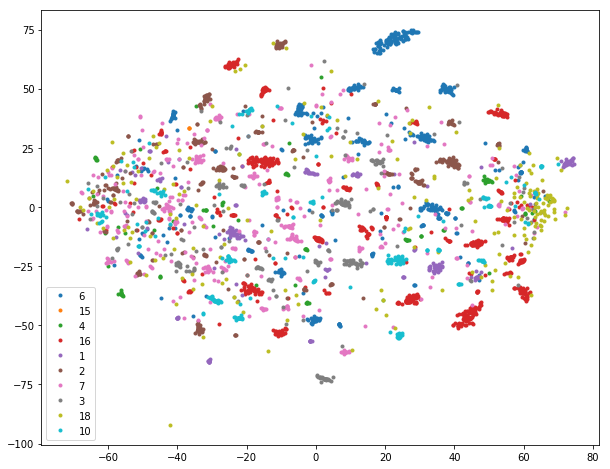

In [148]:
fig, ax = plt.subplots(figsize=(10, 8))
for name in list(gkey)[:10]:
    group = groups.get_group(name)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [90]:
top_fine_cat = ami_ccs.finest_non_empty.value_counts().iloc[:10].index

plot_subdf = plot_df.loc[plot_df.fine_group.isin(top_fine_cat)]

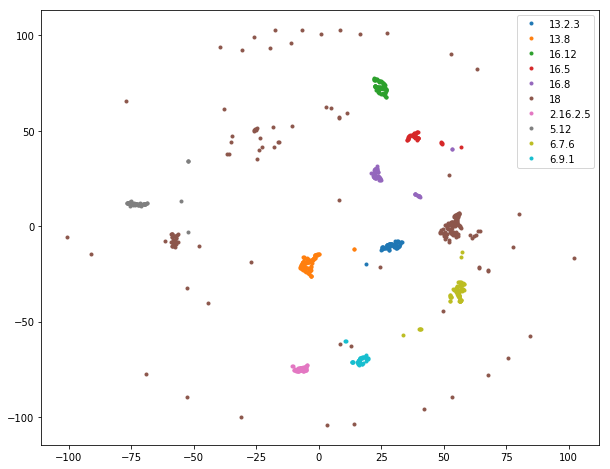

In [91]:
groups = plot_subdf.groupby('fine_group')

fig, ax = plt.subplots(figsize=(10, 8))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [153]:
plot_subdf = plot_df.loc[plot_df.lvl1=='3']

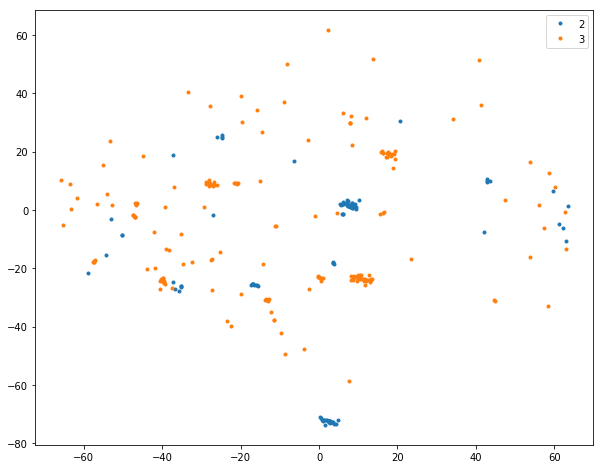

In [154]:
groups = plot_subdf.groupby('level')

fig, ax = plt.subplots(figsize=(10, 8))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [108]:
top_fine_cat

Index(['18', '13.8', '6.7.6', '16.12', '13.2.3', '16.8', '5.12', '6.9.1',
       '16.5', '2.16.2.5', '9.12.3', '16.10.2.7', '1.1.4', '9.2', '3.11.3',
       '3.4', '16.6.1', '17.1.9', '8.9', '10.1.8.3'],
      dtype='object')

### Hyper Tuning

In [68]:
with open('output/hyper_tune_nomask.csv', 'a') as f:
    f.write('DX_dim,hosp_dim,penalty,fc_width,dropout,lr,batch_size,auc\n')

In [35]:
hp = pd.read_csv('output/hyper_tune_nomask.csv')

In [67]:
hp.loc[hp.penalty<0.005]

,DX_dim,hosp_dim,penalty,fc_width,dropout,lr,batch_size,auc
4,16,9,0.000105,32,0.004899,0.00100,64,0.7058
8,65,4,0.000625,16,0.897796,0.00100,256,0.5004
11,94,1,0.001708,64,0.865829,0.00010,512,0.7042
13,50,6,0.000224,32,0.725226,0.00020,128,0.7086
16,15,4,0.002352,32,0.852860,0.00020,512,0.7062
23,48,3,0.000012,64,0.933194,0.00020,512,0.7022
29,28,1,0.001035,32,0.028685,0.00100,256,0.7061
30,57,1,0.000083,256,0.058323,0.00100,512,0.7072
31,43,2,0.000030,64,0.996849,0.00010,128,0.5990
33,43,1,0.000237,64,0.161768,0.00100,128,0.7070


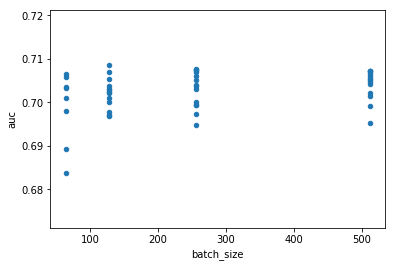

In [104]:
hp.loc[hp.auc>0.68].plot.scatter('batch_size', 'auc')

### Backups

### Model Building with OHE

In [20]:
DX_embed_dim = 50
hosp_embed_dim = 1

In [55]:
input_DX = Input(shape = (n_DX_cat,))
DX_feature = Dense(DX_embed_dim, use_bias=False)(input_DX)

input_demo = Input(shape=(2, ))

input_DX1 = Input(shape=(len(DX1_cat),))

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, DX_feature, hosp_embed], axis=1)

x = Dense(128, activation='relu')(merged)
#x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
#x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [56]:
DX_feature.shape

TensorShape([Dimension(None), Dimension(50)])

In [58]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
checkpoint = ModelCheckpoint(filepath=model_path+'ami_icd9_ohe_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_icd9_ohe_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[demo_mat_val, DX1_mat_val, DX_ohe_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [60]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [61]:
hist = model.fit([demo_mat_trn, DX1_mat_trn, DX_ohe_trn, hosp_array_trn], Y_trn, 
                 batch_size=512, epochs=20, callbacks=[checkpoint, auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[demo_mat_val, DX1_mat_val, DX_ohe_val, hosp_array_val], Y_val], 
                verbose=2)

Train on 145667 samples, validate on 18004 samples
Epoch 1/20
 - 7s - loss: 1.3245 - acc: 0.5939 - val_loss: 0.6438 - val_acc: 0.6399
AUC: 0.6854

Epoch 2/20
 - 9s - loss: 1.2781 - acc: 0.6356 - val_loss: 0.6329 - val_acc: 0.6380
AUC: 0.6898

Epoch 3/20
 - 9s - loss: 1.2583 - acc: 0.6404 - val_loss: 0.6276 - val_acc: 0.6399
AUC: 0.6901

Epoch 4/20
 - 9s - loss: 1.2450 - acc: 0.6460 - val_loss: 0.6301 - val_acc: 0.6279
AUC: 0.6871

Epoch 5/20
 - 9s - loss: 1.2293 - acc: 0.6470 - val_loss: 0.6398 - val_acc: 0.6230
AUC: 0.6841

Epoch 6/20
 - 9s - loss: 1.2162 - acc: 0.6539 - val_loss: 0.6214 - val_acc: 0.6377
AUC: 0.6814

Epoch 7/20
 - 9s - loss: 1.2016 - acc: 0.6574 - val_loss: 0.6104 - val_acc: 0.6439
AUC: 0.6778

Epoch 8/20
 - 9s - loss: 1.1875 - acc: 0.6590 - val_loss: 0.6120 - val_acc: 0.6417
AUC: 0.6747

Epoch 9/20
 - 9s - loss: 1.1727 - acc: 0.6650 - val_loss: 0.6097 - val_acc: 0.6387
AUC: 0.6750

Epoch 10/20
 - 9s - loss: 1.1610 - acc: 0.6660 - val_loss: 0.6189 - val_acc: 0.6329
A